This runs with in Qiskit 1.2.0 environment provided by qbraid.

In [1]:
import os
import numpy as np
import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA

Sampler setup

In [ ]:
USE_BACKEND = "aer"

from qiskit_aer.primitives import Sampler as AerSampler
sampler = AerSampler(run_options={"shots": 4096})

Sampler setup

In [ ]:
tickers_path = "data/prices.csv"

if not os.path.exists(tickers_path):
    import yfinance as yf
    os.makedirs("data", exist_ok=True)
    tickers = ['GOOG', 'XOM', 'AAPL', 'AMZN', 'GLD', 'DUK', 'SO', 'AEP']
    df = yf.download(tickers, start="2017-01-01", end="2017-03-01",
                     group_by="ticker", auto_adjust=True)
    df = df.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index()
    df.to_csv(tickers_path, index=False)
else:
    df = pd.read_csv(tickers_path)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"])
df["Return"] = df.groupby("Ticker")["Close"].pct_change().fillna(0)
df["LogReturn"] = np.log1p(df["Return"])

log_return_vectors = df.groupby("Ticker")["LogReturn"].apply(np.array)
log_return_vectors = log_return_vectors.apply(lambda x: x[x != 0])

tickers = log_return_vectors.index.tolist()
stacked_data = np.vstack(log_return_vectors.values)
X = stacked_data.T
J = stacked_data @ stacked_data.T
print("X shape:", X.shape, " J shape:", J.shape)

X shape: (38, 8)  J shape: (8, 8)


Helper functions

In [ ]:
def Phi(T):
    U, _, Vt = np.linalg.svd(T, full_matrices=False)
    return U @ Vt

def deflate_J(J, b):
    r = float(b.T @ J @ b)
    bbT = np.outer(b, b)
    return J - (2/r) * (J @ bbT @ J) + (J @ bbT @ J @ bbT @ J) / (r**2)

def ising_op_from_J(J):
    D = J.shape[0]
    paulis, coeffs = [], []
    for i in range(D):
        for j in range(i+1, D):
            coeff = -2.0 * J[i, j]
            if abs(coeff) > 1e-12:
                z = ['I'] * D
                z[i] = z[j] = 'Z'
                paulis.append(''.join(reversed(z)))
                coeffs.append(coeff)
    if not paulis:
        return SparsePauliOp.from_list([('I'*D, 0.0)])
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

QAOA solver for each component

In [ ]:
def solve_component_qaoa(J, sampler, reps=2, shots=4096):
    """
    Solve for spin vector b ∈ {-1,+1}^D that maximizes bᵀ J b
    using QAOA (Qiskit 1.2+).
    """
    H = ising_op_from_J(J)
    opt = COBYLA(maxiter=200)

    qaoa = QAOA(sampler=sampler, optimizer=opt, reps=reps)
    result = qaoa.compute_minimum_eigenvalue(H)

    qdist = result.eigenstate  # quasi-distribution
    best_key, best_prob = max(qdist.items(), key=lambda kv: kv[1])

    # Handle both string and integer key types
    if isinstance(best_key, str):
        # Already a bitstring like "0101"
        bits = np.array([int(c) for c in best_key[::-1]])
    else:
        # Convert integer index to bitstring of correct length
        num_qubits = H.num_qubits
        bitstring = format(best_key, f"0{num_qubits}b")
        bits = np.array([int(c) for c in bitstring[::-1]])

    b = 1 - 2 * bits  # map 0→+1, 1→−1

    print(f"[QAOA] best bitstring: {best_key}, as bits={bits[::-1]}")
    return b.astype(float)


def do_l1_pca(J_init, X, K, sampler):
    J = J_init.copy()
    components = []
    for _ in range(K):
        b = solve_component_qaoa(J, sampler)
        components.append(b)
        J = deflate_J(J, b)
    Bopt = np.vstack(components).T
    X_Bopt = X @ Bopt
    R_L1 = Phi(X_Bopt)
    emb = R_L1.T @ X
    return Bopt, R_L1, emb

In [32]:
K = 1
Bopt, R_L1, emb = do_l1_pca(J, X, K, sampler)
print("Bopt:", Bopt[:, 0])

[QAOA] best bitstring: 37, as bits=[0 0 1 0 0 1 0 1]
Bopt: [-1.  1. -1.  1.  1. -1.  1.  1.]


Partition tickers by sign

In [ ]:
group_pos = [tickers[i] for i, v in enumerate(Bopt[:,0]) if v >= 0]
group_neg = [tickers[i] for i, v in enumerate(Bopt[:,0]) if v < 0]

print("\nPartitioned Tickers based on L1 PCA (QAOA):")
print("Group 1:", group_pos)
print("Group 2:", group_neg)


Partitioned Tickers based on L1 PCA (QAOA):
Group 1: ['AEP', 'DUK', 'GLD', 'SO', 'XOM']
Group 2: ['AAPL', 'AMZN', 'GOOG']


In [36]:
K = 2
Bopt, R_L1, emb = do_l1_pca(J, X, K, sampler)
print("Bopt:", Bopt[:, 0])

[QAOA] best bitstring: 218, as bits=[1 1 0 1 1 0 1 0]
[QAOA] best bitstring: 66, as bits=[0 1 0 0 0 0 1 0]
Bopt: [ 1. -1.  1. -1. -1.  1. -1. -1.]


In [37]:
group_pos = [tickers[i] for i, v in enumerate(Bopt[:,0]) if v >= 0]
group_neg = [tickers[i] for i, v in enumerate(Bopt[:,0]) if v < 0]

print("\nPartitioned Tickers based on L1 PCA (QAOA):")
print("Group 1:", group_pos)
print("Group 2:", group_neg)


Partitioned Tickers based on L1 PCA (QAOA):
Group 1: ['AAPL', 'AMZN', 'GOOG']
Group 2: ['AEP', 'DUK', 'GLD', 'SO', 'XOM']


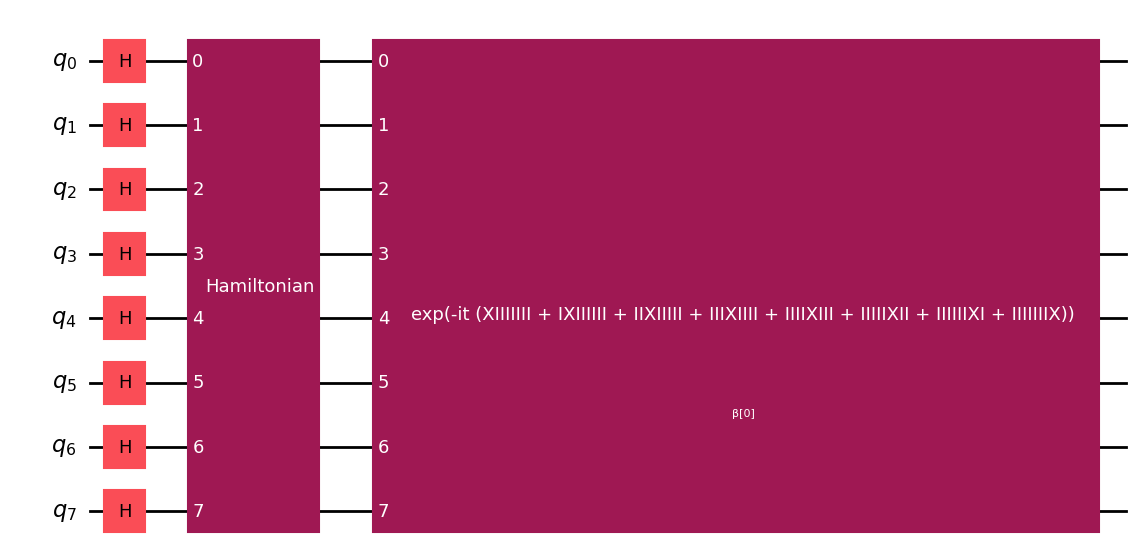

In [46]:
ansatz = QAOAAnsatz(cost_operator=H.to_operator(), reps=1)
ansatz.decompose().draw("mpl")

In [47]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate

def ising_cost_from_J(J: np.ndarray) -> SparsePauliOp:
    """Only ZZ couplings: Hc = sum_{i<j} w_ij Z_i Z_j ."""
    D = J.shape[0]
    paulis, coeffs = [], []
    for i in range(D):
        for j in range(i+1, D):
            w = -2.0 * J[i, j]              # your choice above
            if abs(w) > 1e-12:
                s = ['I'] * D
                s[i] = 'Z'; s[j] = 'Z'
                # Qiskit uses little-endian strings: rightmost char = qubit-0.
                paulis.append(''.join(reversed(s)))
                coeffs.append(w)
    if not paulis:
        return SparsePauliOp.from_list([('I'*D, 0.0)])
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

def build_qc_l1pca_qaoa(J: np.ndarray, p: int = 1):
    """
    Build a *clean* QAOA circuit:
      - H layer
      - [ cost ZZ evolution with γ_k ] + [ mixer RX with β_k ] repeated p times
    Uses one γ_k and one β_k per layer (standard QAOA). No one-body Z terms.
    """
    D = J.shape[0]
    q = QuantumRegister(D, "q")
    qc = QuantumCircuit(q)

    # Parameters: one gamma and one beta per layer
    gammas = ParameterVector("γ", p)
    betas  = ParameterVector("β", p)

    # Initial Hadamards
    for i in range(D):
        qc.h(q[i])

    # Cost operator (ZZ only)
    cost_op = ising_cost_from_J(J)

    # p layers
    for k in range(p):
        # Cost evolution: exp(-i * gamma_k * Hc)
        qc.append(PauliEvolutionGate(cost_op, time=gammas[k]), q[:])

        # Mixer: Rx(2*beta_k) on each qubit  ≡ exp(-i * beta_k * X_i)
        for i in range(D):
            qc.rx(2 * betas[k], q[i])

    return qc, gammas, betas


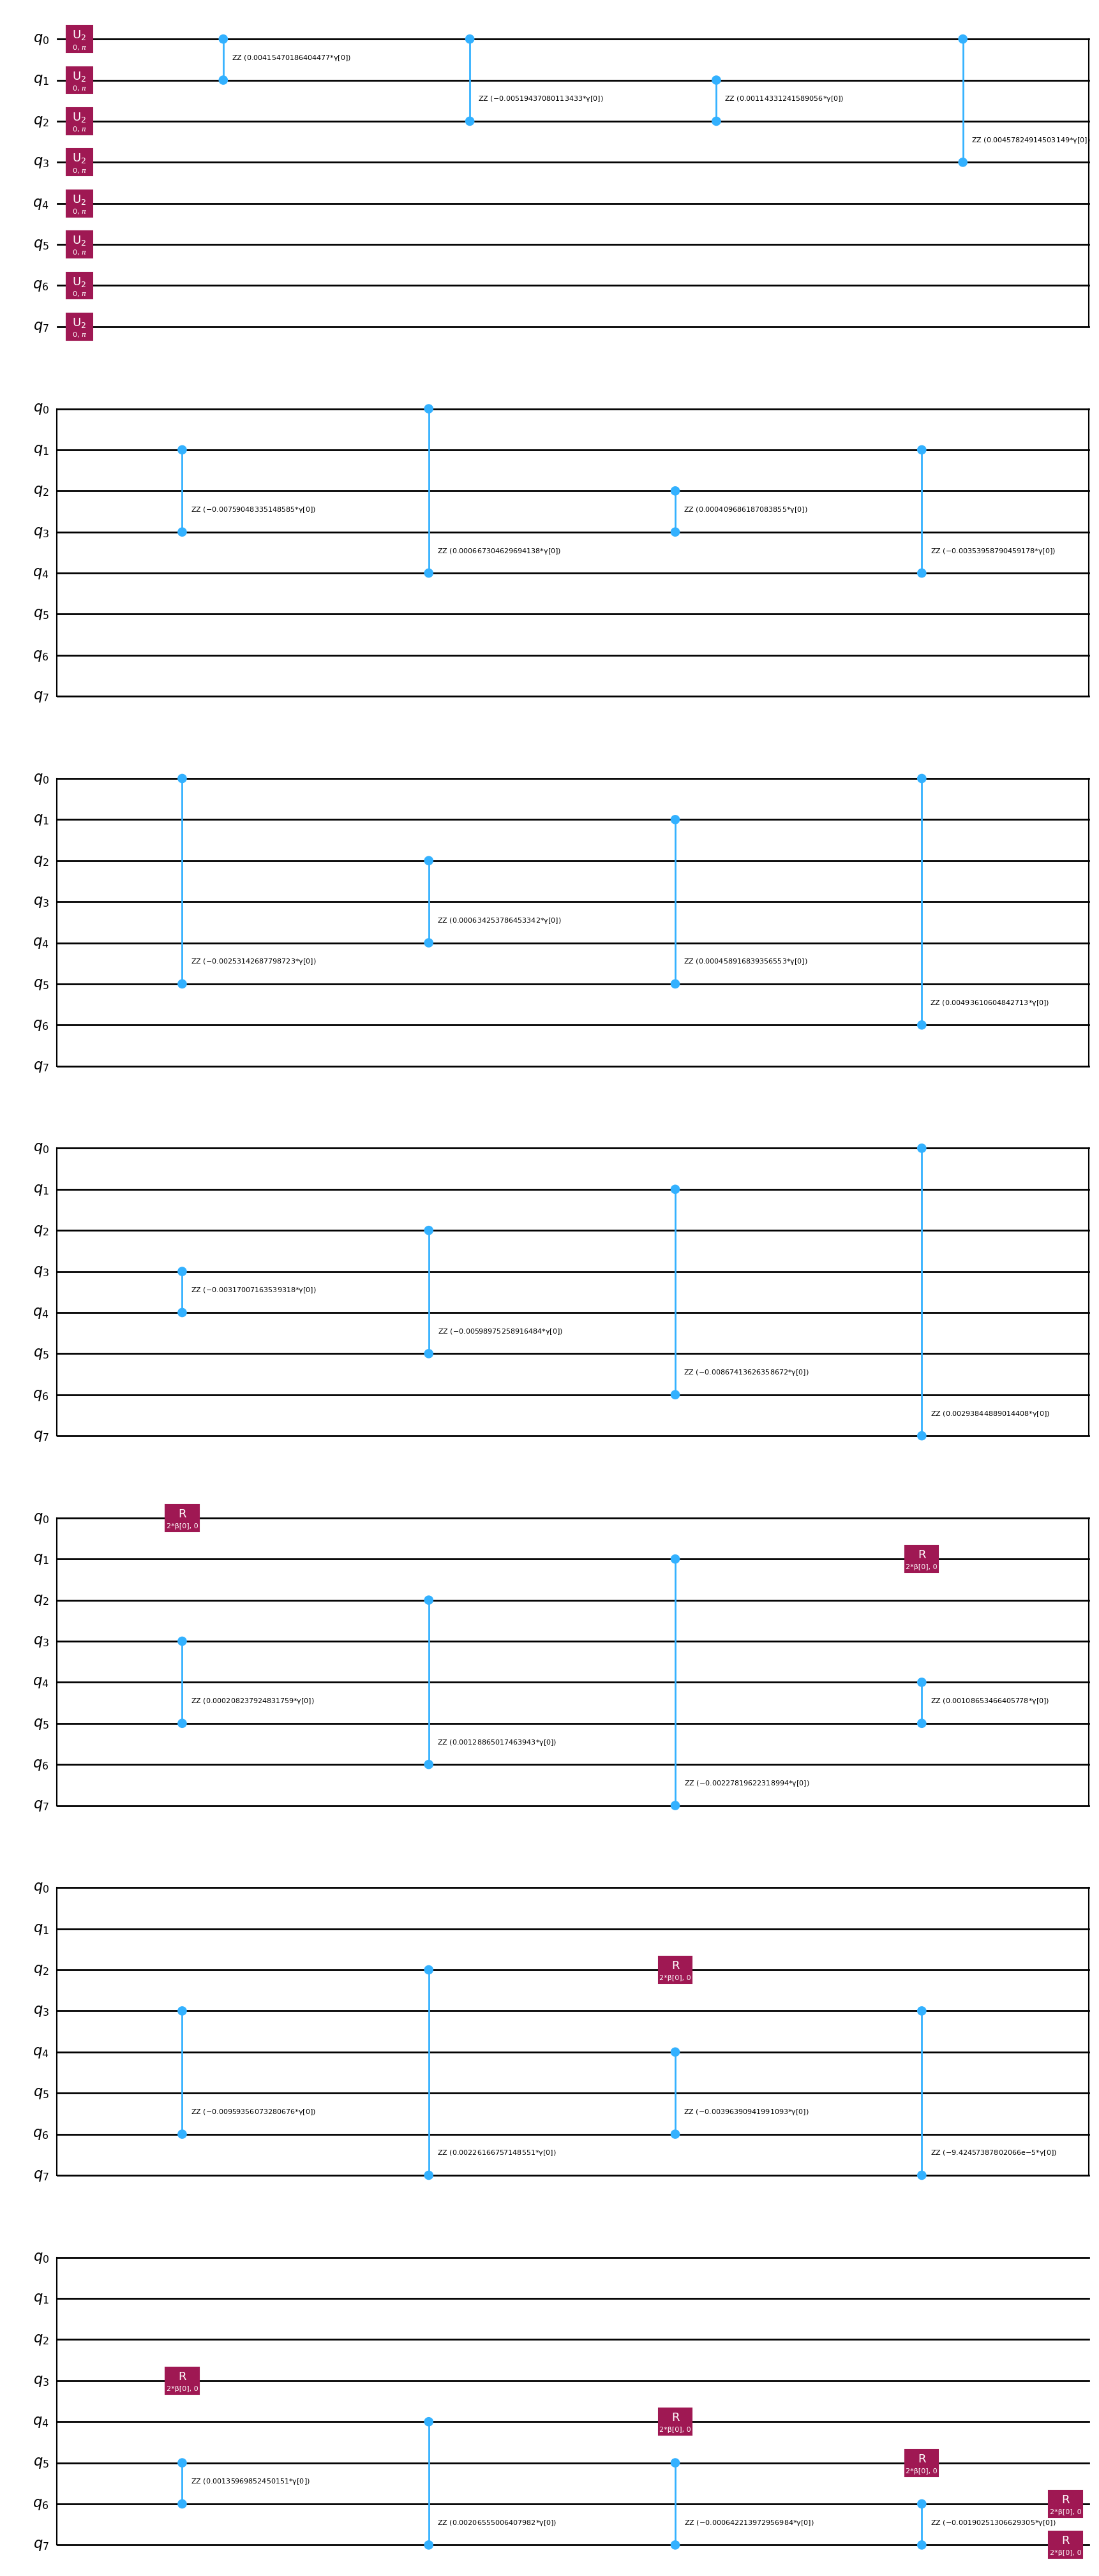

In [48]:
qc, gammas, betas = build_qc_l1pca_qaoa(J, p=1)
qc.decompose().draw("mpl")